#### Installations

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.5 MB/s eta 0:00:00


#### Imports

In [ ]:
import nltk
import re
import string
import torch
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from tqdm.notebook import tqdm

from datetime import datetime, timedelta
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#### Global Variables

In [ ]:
random_state = 42

## Data

#### Generate manual data to meet explainations

In [ ]:

df = pd.read_csv("trainn.csv")
df.drop(['Unnamed: 0'], inplace=True, axis=1)

df.category.value_counts()

society-culture                      10060
comedy                                8058
religion-spirituality                 7577
business                              6198
arts                                  5570
education                             5324
tv-film                               5117
christianity                          4990
music                                 4116
technology                            2324
society-culture-personal-journals     1666
kids-family                           1652
business-careers                      1399
spirituality                          1152
arts-performing-arts                  1076
society-culture-places-travel          831
society-culture-philosophy             765
business-investing                     713
arts-visual-arts                       710
arts-food                              606
arts-design                            346
arts-fashion-beauty                    246
judaism                                148
islam      

In [ ]:

df = pd.read_csv("trainn.csv")
df.drop(['Unnamed: 0'], inplace=True, axis=1)
df["category"] = df["category"].replace({
    'buddhism': 'Religion-Spirituality', 'islam': 'Religion-Spirituality', 'hinduism': 'Religion-Spirituality', 'judaism': 'Religion-Spirituality', 'christianity': 'Religion-Spirituality',
'religion-spirituality': 'Religion-Spirituality','spirituality': 'Religion-Spirituality',
'arts-fashion-beauty': 'Arts','arts-design': 'Arts','arts-food': 'Arts','arts-visual-arts': 'Arts','arts-performing-arts': 'Arts','arts': 'Arts',
  'society-culture-philosophy': 'Society Culture','society-culture-places-travel': 'Society Culture','society-culture-personal-journals': 'Society Culture','society-culture': 'Society Culture',
    'business-investing': 'Business','business-careers': 'Business','business': 'Business'


    }
)


#### Set up the automatic data generation

In [ ]:
# Parameters
n_teams = len(df.category.unique())  # Specify the number of teams
lambda_val = 50 # Exponential distribution parameter
random.seed(random_state)

# Generate the team names
team_names = []
for i in range(n_teams):
    for j in string.ascii_lowercase:
        for k in string.ascii_lowercase:
            team_names.append("team_{}{}".format(j, k))

# Generate the distribution values
probabilities = np.random.exponential(scale=1/lambda_val, size=n_teams)
probabilities /= np.sum(probabilities)  # Normalize probabilities to sum up to 1

# Create dictionary with team names as keys and probabilities as values
team_distribution = OrderedDict(zip(team_names, probabilities))

In [ ]:
print(len(team_distribution))

10


#### Generate the data

## Preprocess the data

#### Keep the original description

#### Stopwords

In [ ]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

df["content"] = df["content"].apply(lambda x: " ".join([word for word in x.split() if word.lower() not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df["content"].head(5)

0    Thanks providing insights. Really enjoy variet...
1    Super excited see podcast grow. many fun topic...
2    I'm liberal myself, pretty obvious annoying th...
3    find Tedx talks inspirational often don’t time...
4                                  love podcast, good.
Name: content, dtype: object

#### Punctuation

In [ ]:
# Define a regex string to match punctuation (+ the underscore character)
regex = r"[^\w\s]|_"

# Define a lambda function to REPLACE punctuation from a string by a space character
remove_punct = lambda text: re.sub(regex, " ", text)

# Apply the remove_punct function to the "description" column
df["content"] = df["content"].apply(remove_punct)

In [ ]:
df["content"].head(5)

0    Thanks providing insights  Really enjoy variet...
1    Super excited see podcast grow  many fun topic...
2    I m liberal myself  pretty obvious annoying th...
3    find Tedx talks inspirational often don t time...
4                                  love podcast  good 
Name: content, dtype: object

#### Lowercase

In [ ]:
df["content"] = df["content"].str.lower()

In [ ]:
df["content"].head(5)

0    thanks providing insights  really enjoy variet...
1    super excited see podcast grow  many fun topic...
2    i m liberal myself  pretty obvious annoying th...
3    find tedx talks inspirational often don t time...
4                                  love podcast  good 
Name: content, dtype: object

#### Numbers

In [ ]:
df["content"] = df["content"].apply(lambda x: " ".join(re.findall(r"\d*[a-zA-Z][\w]*", x)))

In [ ]:
df["content"].head(5)

0    thanks providing insights really enjoy variety...
1    super excited see podcast grow many fun topics...
2    i m liberal myself pretty obvious annoying the...
3    find tedx talks inspirational often don t time...
4                                    love podcast good
Name: content, dtype: object

## Preprocess the labels

#### Team occurences

In [ ]:
# Note that there are 100 possible teams but since some have really low probabilities, it is possible that some doens"t appears in any incidents
len(df["category"].unique())

10

In [ ]:
team_counts = df["category"].value_counts().reset_index()
team_counts.columns = ["category", "count"]

In [ ]:
team_counts

,category,count
0,Religion-Spirituality,14095
1,Society Culture,13322
2,Arts,8554
3,Business,8310
4,comedy,8058
5,education,5324
6,tv-film,5117
7,music,4116
8,technology,2324
9,kids-family,1652


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(team_counts, *['count'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(team_counts, *['count'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['index'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_1, *['count'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_2, *['index'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_3, *['count'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_4, *[[['index', 'count']]], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_5, *['index', 'count', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_6, *['index', 'count()', None], **{})
chart

#### Team occurence above a quantile

In [ ]:
top_team_counts = team_counts[team_counts["count"] >= team_counts.quantile(0.4)[0]]
top_teams = top_team_counts["category"].values

<ipython-input-15-1ffb7ce47513>:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  top_team_counts = team_counts[team_counts["count"] >= team_counts.quantile(0.4)[0]]


In [ ]:
top_team_counts

,category,count
0,Religion-Spirituality,14095
1,Society Culture,13322
2,Arts,8554
3,Business,8310
4,comedy,8058
5,education,5324


#### Match each team to a value

In [ ]:
team_mapping = {}
number = 0
for team in top_teams:
  if team not in team_mapping:
    team_mapping[team] = number
    number += 1
print(number)

6


In [ ]:
df["team_number"] = df["category"].apply(lambda team: team_mapping[team] if team in team_mapping else number)

In [ ]:
df[["category", "team_number"]]

,category,team_number
0,Arts,2
1,Arts,2
2,music,6
3,Arts,2
4,Arts,2
...,...,...
70867,Arts,2
70868,Religion-Spirituality,0
70869,music,6
70870,Society Culture,1


#### Rerun the team occurence based on the team number to have the "-1" group

In [ ]:
team_number_counts = df["team_number"].value_counts().reset_index()
team_number_counts.columns = ["team_number", "count"]

In [ ]:
team_number_counts

,team_number,count
0,0,14095
1,1,13322
2,6,13209
3,2,8554
4,3,8310
5,4,8058
6,5,5324


#### Distribution of the team occurence

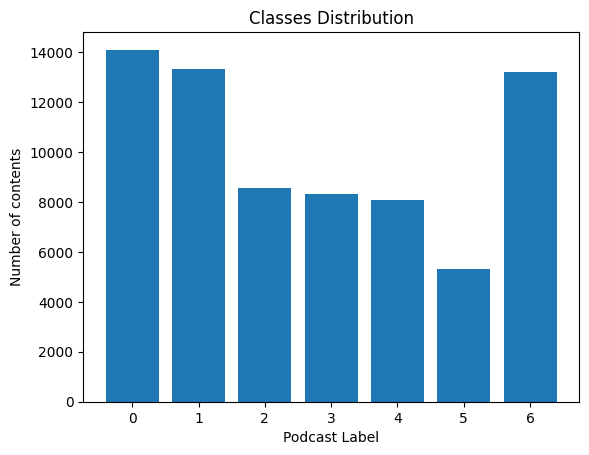

In [ ]:
# Plot the graph
plt.bar(team_number_counts["team_number"], team_number_counts["count"])

# Set labels and title
plt.xlabel("Podcast Label")
plt.ylabel("Number of contents")
plt.title("Classes Distribution")

# Show the plot
plt.show()

## Train & Test sets

In [ ]:
test_ratio = 0.2
train_ind, test_ind = train_test_split(df.index, test_size=test_ratio, shuffle=True, random_state=random_state)

train_df = df.loc[train_ind, :]
test_df = df.loc[test_ind, :]

In [ ]:
print(df.shape)
print(train_df.shape)
print(test_df.shape)

(70872, 3)
(56697, 3)
(14175, 3)


## Balance the labels of the training set

In [ ]:
min_train_count = train_df["team_number"].value_counts().min()
min_train_count

4205

In [ ]:
train_df = pd.concat([group.sample(min_train_count) for name, group in train_df.groupby("team_number")])

In [ ]:
train_team_counts = train_df["team_number"].value_counts().reset_index()
train_team_counts.columns = ["team_number", "count"]

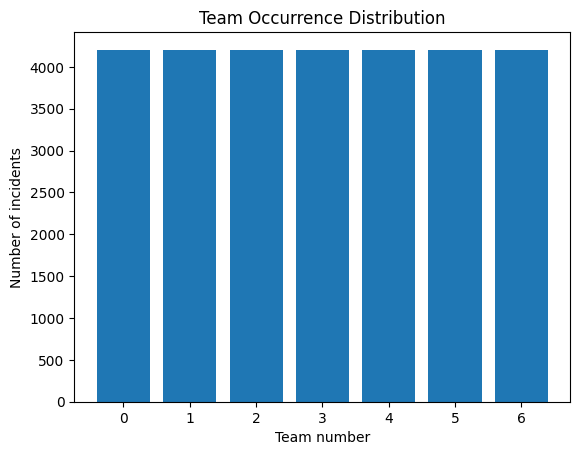

In [ ]:
# Plot the graph
plt.bar(train_team_counts["team_number"], train_team_counts["count"])

# Set labels and title
plt.xlabel("Team number")
plt.ylabel("Number of incidents")
plt.title("Team Occurrence Distribution")

# Show the plot
plt.show()

## Get the text and the labels

In [ ]:
text = train_df["content"].values
labels = train_df["team_number"].values

In [ ]:
print(text.shape)
print(labels.shape)

(29435,)
(29435,)


## Tokenize

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(train_team_counts), output_attentions=False, output_hidden_states=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Get the token_ids and attention_masks

In [ ]:
token_ids = []
attention_masks = []
for description in text:
  encoding_dict = tokenizer.encode_plus(description, add_special_tokens=True, max_length=256 ,  pad_to_max_length=True, return_attention_mask=True, return_tensors="pt")
  token_ids.append(encoding_dict["input_ids"])
  attention_masks.append(encoding_dict["attention_mask"])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


#### Get in torch tensors

In [ ]:
token_ids = torch.cat(token_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

## Train & Validation sets

In [ ]:
# Parameters
val_ratio = 0.2
batch_size = 32

# Indices of the train and validation splits stratified by labels
train_ind, val_ind = train_test_split(np.arange(len(labels)), test_size=val_ratio, shuffle=True, stratify=labels, random_state=random_state)

# Prepare TensorsDataset
train_set = TensorDataset(token_ids[train_ind], attention_masks[train_ind], labels[train_ind])
val_set = TensorDataset(token_ids[val_ind], attention_masks[val_ind], labels[val_ind])

# Prepare DataLoader
train_dataloader = DataLoader(train_set, sampler=RandomSampler(train_set), batch_size=batch_size)
val_dataloader = DataLoader(val_set, sampler=SequentialSampler(val_set), batch_size=batch_size)

## Training

## Validation metrics

In [ ]:
def f1_score_func(predictions, labels):
    preds_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average="weighted")

In [ ]:
label_dict = pd.Series(df["team_number"].values, index=df["category"]).to_dict()

In [ ]:
def accuracy_per_class(predictions, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    predictions_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_predictions = predictions_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f"Class: {label_dict_inverse[label]}")
        print(f"Accuracy: {len(y_predictions[y_predictions==label])}/{len(y_true)}\n")

#### Training Setup

In [ ]:
epochs = 2
optimizer = AdamW(model.parameters(), lr=1e-2, eps=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)

In [ ]:
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda


#### Training

In [ ]:
def evaluate(val_dataloader):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in val_dataloader:

        batch = tuple(b.to(device) for b in batch)

        inputs = {"input_ids":      batch[0],
                  "attention_mask": batch[1],
                  "labels":         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs["labels"].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(val_dataloader)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(train_dataloader, desc="Epoch {:1d}".format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {"input_ids":      batch[0],
                  "attention_mask": batch[1],
                  "labels":         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({"training_loss": "{:.3f}".format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f"/content/finetuned_BERT_epoch_{epoch}.model")

    tqdm.write(f"\nEpoch {epoch}")

    loss_train_avg = loss_train_total/len(train_dataloader)
    tqdm.write(f"Training loss: {loss_train_avg}")

    val_loss, predictions, true_vals = evaluate(val_dataloader)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f"Validation loss: {val_loss}")
    tqdm.write(f"F1 Score (Weighted): {val_f1}")

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/736 [00:00<?, ?it/s]


Epoch 1
Training loss: 2.5218207014967566
Validation loss: 2.1693949336590976
F1 Score (Weighted): 0.03571428571428571


Epoch 2:   0%|          | 0/736 [00:00<?, ?it/s]


Epoch 2
Training loss: 2.141638848606659
Validation loss: 1.9521435389052266
F1 Score (Weighted): 0.03571428571428571


## Predict

#### Prepare the data

In [ ]:
test_text = test_df["content"].values
test_labels = test_df["team_number"].values

In [ ]:
test_token_ids = []
test_attention_masks = []
for test_description in test_text:
  test_encoding_dict = tokenizer.encode_plus(test_description, add_special_tokens=True, max_length=256, pad_to_max_length=True, return_attention_mask=True, return_tensors="pt")
  test_token_ids.append(test_encoding_dict["input_ids"])
  test_attention_masks.append(test_encoding_dict["attention_mask"])

In [ ]:
test_token_ids = torch.cat(test_token_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test_labels)

In [ ]:
test_set = TensorDataset(test_token_ids, test_attention_masks, test_labels)
test_dataloader = DataLoader(test_set, sampler=RandomSampler(test_set), batch_size=batch_size)

#### Evaluate the test samples

In [ ]:
_, test_predictions, test_true_vals = evaluate(test_dataloader)

#### Scores

In [ ]:
test_f1_weighted = f1_score_func(test_predictions, test_true_vals)
print(f"F1 Score (Weighted): {test_f1_weighted}")

In [ ]:
accuracy_per_class(test_predictions, test_true_vals)